In [140]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [141]:
# Bigger font
sns.set(font_scale=1.3)
plt.style.use('fivethirtyeight')
# Figure size®
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 2.5
rcParams['lines.marker'] = '.'
rcParams['lines.linewidth'] = 1
rcParams['lines.markersize'] = 5
rcParams['legend.fontsize'] = 10
rcParams['axes.titlesize'] = 16
# plt.rc('figure.subplot', wspace=.33)
# Slides
from notebook.services.config import ConfigManager
cm = ConfigManager()
# cm.update('livereveal', {'width': 1024, 'height': 768, 'scroll': True, 'theme': 'simple', 'transition': 'linear'});
# np.random.seed(123)

from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"  # print not only the last variable
%config InlineBackend.figure_format ='retina'  # retine quality plots

## Introduction

- GPs estimate the uncertainty of predictions.

### Gaussian Random Process in Math

A random process $\big\{X(t), t \in J \big\}$ is a Gaussian Random Process if for all $ t_1,t_2, \dots, t_n \in J$, the random variables

$$
X\left(t_{1}\right), X\left(t_{2}\right), \ldots, X\left(t_{n}\right)
$$

are **jointly normal**.

### Gaussian Random Process in ML

A random process $\big\{f(x_i), x_i\in \mathbb R^d \big\}$ is a Gaussian Random Process if for all $x_i \in \mathbb R^d$, the random variables

$$
f\left(x_{1}\right), f\left(x_{2}\right), \ldots, f\left(x_{n}\right)
$$

are **jointly normal**.

$$
\left( \begin{array}{c}{f\left(x_{1}\right)} \\ {f\left(x_{2}\right)} \\ {\cdots} \\ {f\left(x_{n}\right)}\end{array}\right) \sim \mathcal{N}
$$

## Complexity

- Training time $O(n^3)$
- Storage $O(n^2)$
- Test prediction $O(n^2)$



The explanation for Gaussian Processes from CS229 Notes is the best I found and understood

http://cs229.stanford.edu/section/cs229-gaussian_processes.pdf

Here, I'll be covering the main points behind this method, and I'll be using code from 

https://blog.dominodatalab.com/fitting-gaussian-process-models-python/

who happens to have many great repositories with jupyter notebooks regarding ML

https://github.com/fonnesbeck?tab=repositories

## Notation

Training set of i.i.d. examples drawn from some unknown distribution.
$$
S = \{(x^{(i)}, y^{(i)})\}_{i=1}^{m}
$$

Testing set of i.i.d. examples drawn from the same distribution as S.
$$
T = \{(x^{(i)}_*, y^{(i)}_*)\}_{i=1}^{m}
$$

We have to fit this model
$$
\begin{align}
y^{(i)} = w^T x^{(i)} + \epsilon^{(i)} \\
\epsilon^{(i)} \sim \mathcal N (0, \sigma^2) \space \space i.i.d
\end{align}
$$

But in a Gaussian Process (GP), the **model** will look like this
$$
y^{(i)} = f(x^{(i)}) + \epsilon^{(i)}
$$

or in matrix form
$$
\vec{y} = f(X) + \vec{\epsilon}
$$

because the point with GP to find a distribution over the possible functions $f$ that are consistent with the observed data.

## Data

When modeling $f$ as a GP, there is

Training set:
![](images/a.png)

Testing set:
![](images/b.png)

We will basically only use $X$ and $f$ which is observed data and $X_*$ and $f_*$ which is unobserved data.

And in the end this the goal is to estimate outputs $f_*$ for a set of new inputs $X_*$

## Partitioning

There is this common theorem:

A random vector $\vec{x} \in \mathbb R^n$ with $\vec{x} \sim \mathcal N (\vec{\mu}, \Sigma)$ that is partitioned into two subvectors $\vec{x}_1 \in \mathbb R^p$ and $\vec{x}_2\in \mathbb R^q$ with $p+q = n$

$$
\vec{x} =
\begin{bmatrix}
\vec{x}_1 \\
\vec{x}_2
\end{bmatrix}
$$

such that

$$
\vec{\mu}=\begin{bmatrix}
 \vec{\mu}_1 \\
 \vec{\mu}_2
\end{bmatrix}
$$

$$
\Sigma=\begin{bmatrix}
\Sigma_{\vec{x}_1\vec{x}_1} & \Sigma_{\vec{x}_1\vec{x}_2}\\
\Sigma_{\vec{x}_2\vec{x}_1} & \Sigma_{\vec{x}_2\vec{x}_2}
\end{bmatrix}=\begin{bmatrix}
\Sigma_{11} & \Sigma_{12}\\
\Sigma_{21} & \Sigma_{22}
\end{bmatrix}=\begin{bmatrix}
\Sigma_{11} & \Sigma_{12}\\
\Sigma_{12}^T & \Sigma_{22}
\end{bmatrix}
$$

Because $\Sigma$ is symmetric, $\Sigma = \Sigma^T$ and $\Sigma_{21} = \Sigma_{12}^T$

In other words, there is this joint distribution

$$
\begin{bmatrix}
\vec{x}_1 \\
\vec{x}_2
\end{bmatrix}
\sim \mathcal{N}{\left(
\begin{bmatrix}
 \vec{\mu}_1 \\
 \vec{\mu}_2
\end{bmatrix}
,
\begin{bmatrix}
\Sigma_{11} & \Sigma_{12}\\
\Sigma_{12}^T & \Sigma_{22}
\end{bmatrix}
\right)}
$$

For that case, the following properties hold:
- Normalization: Probabilities sum 1
- Marginalization: The marginal distributions of $x_1$ and $x_2$ are Gaussian

$$
\begin{align}
\vec{x}_1 \sim \mathcal N (\vec{\mu}_1, \Sigma_{11})\\
\vec{x}_2 \sim \mathcal N (\vec{\mu}_2, \Sigma_{22})
\end{align}
$$

- Conditioning: The conditional distribution of $\vec{x}_i$ given $\vec{x}_j$ is also normal with

$$
\begin{align}
\vec{\mu}_{1|2} = \vec{\mu}_1 + \Sigma_{12}\Sigma_{22}^{-1}(\vec{x}_2 - \vec{\mu}_2)\\
\Sigma_{1|2} = \Sigma_{11} - \Sigma_{12}\Sigma_{22}^{-1}\Sigma_{21}
\end{align}
$$

The derivation for this is here http://fourier.eng.hmc.edu/e161/lectures/gaussianprocess/node7.html

The part of the $\Sigma_{i|j}$ in the theorem isn't right though the rest is ok.

## Kernel Function

$$
K_{XX'} = K(X,X') = \left(
\begin{matrix}
k(x_1, x_1') \\ \vdots \\ k(x_m, x_1')
\end{matrix}
\begin{matrix}
\cdots \\ \ddots \\ \cdots 
\end{matrix} 
\begin{matrix}
k(x_1, x_m') \\ \vdots \\ k(x_m, x_m')
\end{matrix}
\right)
$$

And example of one is squared exponential kernel, a.k.a Gaussian kernel, a.k.a RBF kernel

$$
k_{\textrm{SE}}(x, x') = \sigma^2\exp\left(-\frac{(x - x')^2}{2\ell^2}\right)
$$

In [142]:
import numpy as np

def exponential_cov(x, y, params):
    return params[0]**2 * np.exp(-np.subtract.outer(x, y)**2 / (2*params[1]**2))

θ = [1, 1]
exponential_cov([1, 2], [1, 2], θ)

array([[1.        , 0.60653066],
       [0.60653066, 1.        ]])

This can show what this distance measure does

In [143]:
exponential_cov([1], [1,2,3,4], θ)

array([[1.        , 0.60653066, 0.13533528, 0.011109  ]])

## Joint Distribution

**I'll stop using the $\vec{}$ that refers to a vector.**

That theorem of partitioning is useful here because we assume that there was a partition that gave us $f$ and $f_*$

Consequently, $f$ and $f_*$ have their own mean and variance just like in the theorem.

$$
\begin{align}
f \sim \mathcal N (\mu, \Sigma)\\
f_* \sim \mathcal N (\mu_*, \Sigma_{**})
\end{align}
$$

However, $\Sigma$ is noted as $K$ for kernel because it's computation will vary according to a kernel function.

$$
\begin{align}
f \sim \mathcal N (\mu, K)\\
f_* \sim \mathcal N (\mu_{*}, K_{**})
\end{align}
$$

$$
\begin{pmatrix}
f \\
f_{*}
\end{pmatrix}
\sim \mathcal{N}{\left(
\begin{pmatrix}
\mu \\
\mu_{*}
\end{pmatrix}
,
\begin{pmatrix}
K & K_{*}\\
K_{*}^T & K_{**}\\
\end{pmatrix}
\right)}
$$

Where

$
f, \mu \in \mathbb R^m
$

$
f_*, \mu_* \in \mathbb R^{m_*}
$

$
K = K(X,X)$ is $m\times m
$

$
K_* = K(X,X_*)$ is $m\times m_*
$

$
K_{**} = K(X_*,X_*)$ is $m_*\times m_*
$

## Posterior

Because of the theorem

$$
\begin{align}
\vec{\mu}_{1|2} = \vec{\mu}_1 + \Sigma_{12}\Sigma_{22}^{-1}(\vec{x}_2 - \vec{\mu}_2)\\
\Sigma_{1|2} = \Sigma_{11} - \Sigma_{12}\Sigma_{22}^{-1}\Sigma_{21}
\end{align}
$$

The posterior $p(f_* | f) = p(f_* | f, X_*, X)$ is

$$
p(f_* | f, X_*, X) = \mathcal N(\mu^*, \Sigma^*)
$$

$$
\begin{align}
\mu^* = \mu_* +K_{*}^T K^{-1}(f - \mu)\\
\Sigma^* = K_{**} - K_{*}^T K^{-1} K_{*}
\end{align}
$$

## Prior

As with every bayesian method, a prior probability $p(f_*)$ has to be defined.

## Gaussian Process (GP)

It is denoted using this notation

$$
k_{\textrm{SE}}(x, x') = \sigma^2\exp\left(-\frac{(x - x')^2}{2\ell^2}\right)
$$

$$
f(x) \sim \mathcal{GP}(m(x), k(x,x'))
$$

Or like this as there are parameters the **MEAN FUNCTION** and **COVARIANCE FUNCTION**

$$
f(x) \sim \mathcal{GP}(m(x|\theta_m), k(x,x'|\theta_c))
$$

This will find a distribution of parameters over all possible functions $f(x)$ (this is constrained because they are too many).

## Sample functions from some priors

In [144]:
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

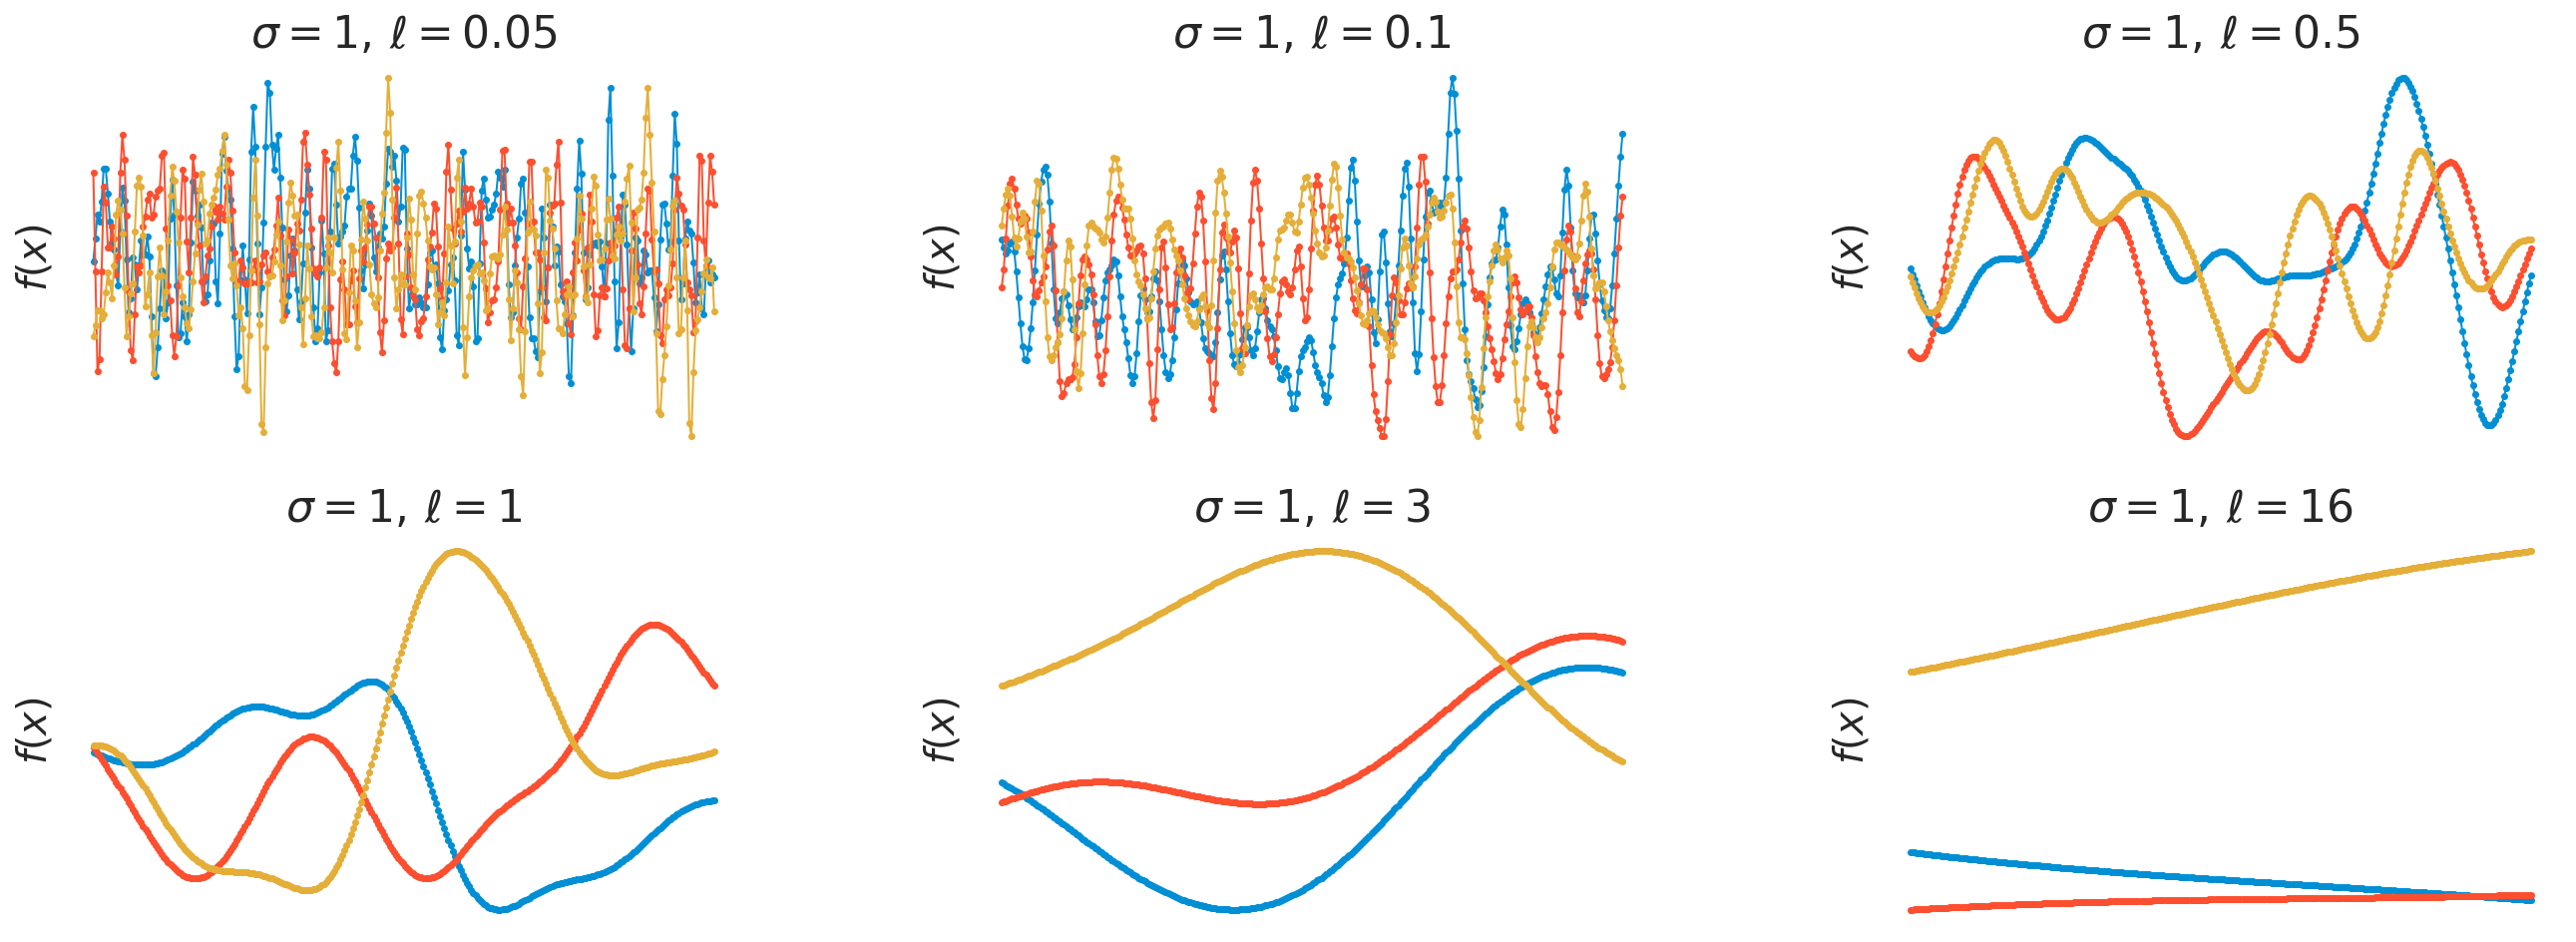

In [145]:
def plot_gp(ax, kernel, plot_xs, params, n_samples=10, xlab=False, ylab=False):
    sampled_funcs = np.random.multivariate_normal(np.zeros(len(plot_xs)), exponential_cov(plot_xs, plot_xs, params), size=3)
    ax.plot(plot_xs, sampled_funcs.T)
    ax.set_title(r'$\sigma = {},\/ \ell = {} $'.format(\
        params[0], params[1]), fontsize = 22)
    if xlab:
        ax.set_xlabel(r'$x$',fontsize = 20)
    if ylab:
        ax.set_ylabel(r'$f(x)$',fontsize = 20)

fig = plt.figure(figsize=(20,8), facecolor='white')
ax_1 = fig.add_subplot(231, frameon=False)
ax_2 = fig.add_subplot(232, frameon=False)
ax_3 = fig.add_subplot(233, frameon=False)
ax_4 = fig.add_subplot(234, frameon=False)
ax_5 = fig.add_subplot(235, frameon=False)
ax_6 = fig.add_subplot(236, frameon=False)
ax_1.set_xticks([])
ax_1.set_yticks([])
ax_2.set_xticks([])
ax_2.set_yticks([])
ax_3.set_xticks([])
ax_3.set_yticks([])
ax_4.set_xticks([])
ax_4.set_yticks([])
ax_5.set_xticks([])
ax_5.set_yticks([])
ax_6.set_xticks([])
ax_6.set_yticks([])

plot_xs = np.linspace(-5, 5, 300)
plot_gp(ax_1, exponential_cov, plot_xs, [1, 0.05], 3, ylab=True)
plot_gp(ax_2, exponential_cov, plot_xs, [1, 0.1], 3, ylab=True)
plot_gp(ax_3, exponential_cov, plot_xs, [1, 0.5], 3, ylab=True)
plot_gp(ax_4, exponential_cov, plot_xs, [1, 1], 3, ylab=True)
plot_gp(ax_5, exponential_cov, plot_xs, [1, 3], 3, ylab=True)
plot_gp(ax_6, exponential_cov, plot_xs, [1, 16], 3, ylab=True)

## Prediction

The idea of prediction with Gaussian Processes boils down to

"Given my old x, and the y values for those x, what do I expect y to be for a new x?".

We are then given the following information:

x = [1, 2, 3, 5, 7, 10]  
y = [-0.3, 0.3, 0.5, -1.2, 0.7, -0.5]

Now, what is your best guess for $y$ when $x = 6$?

My best guess would be $y = 0$

To guess that with a GP, we have to implement

$$
p(f_* | f, X_*, X) = \mathcal N(\mu^*, \Sigma^*)
$$

$$
\begin{align}
\mu^* = \mu_* +K_{*}^T K^{-1}(f - \mu)\\
\Sigma^* = K_{**} - K_{*}^T K^{-1} K_{*}
\end{align}
$$

where 

$
K = K(X,X)$ is $m\times m
$

$
K_* = K(X,X_*)$ is $m\times m_*
$

$
K_{**} = K(X_*,X_*)$ is $m_*\times m_*
$

And I'll use the prior 

$$
f(x) \sim \mathcal{GP}(m(x) = 0, k(x,x'))
$$

Meaning that

$$
\begin{align}
f \sim \mathcal N (\mu = \mathbf0_{m}, K)\\
f_* \sim \mathcal N (\mu_{*} = \mathbf0_{m_*}, K_{**})
\end{align}
$$

Because that is the most common prior, the poterior is normally this one

$$
p(f_* | f, X_*, X) = \mathcal N(\mu^*, \Sigma^*)
$$

$$
\begin{align}
\mu^* = K_{*}^T K^{-1}f\\
\Sigma^* = K_{**} - K_{*}^T K^{-1} K_{*}
\end{align}
$$

or

$$
p(y_* | y, X_*, X) = \mathcal N(K_{*}^T K^{-1}y, K_{**} - K_{*}^T K^{-1} K_{*})
$$

In [146]:
x = np.array([1, 2, 3, 5, 7, 10])
y = [-0.3, 0.3, 0.5, -1.2, 0.7, -0.5]

In [147]:
def posterior(x_new, x, y, kernel, params):
    k = kernel(x, x, params)
    k_s = kernel(x, x_new, params)
    k_ss = kernel(x_new, x_new, params)
    post_mean = (k_s.T).dot(np.linalg.pinv(k)).dot(y)
    post_variance = k_ss - (k_s.T).dot(np.linalg.pinv(k)).dot(k_s)
    return post_mean, post_variance

## Fit and predict

A train function or "fit" in scikit learn will only store the values of x and y in memory because unlike other type of learning algorithm, when having test data to evaluate, this method needs to consider the whole dataset again. As a consequence, "predicting" is a costly process.

Predicting a value

In [148]:
params = [1, 1]

x_new = [6]
mean, variance = posterior(x_new, x, y, exponential_cov, params)
mean, variance

(array([-0.30152242]), array([[0.34578349]]))

The mean is approximately the true value of y_new

## Plotting a confidence region around an expected function

In [149]:
x_pts = np.arange(x.min()-5, x.max()+5, step=0.01)
mean, variance = posterior(x_pts, x, y, exponential_cov, params)
y_pts = np.random.multivariate_normal(mean, variance)

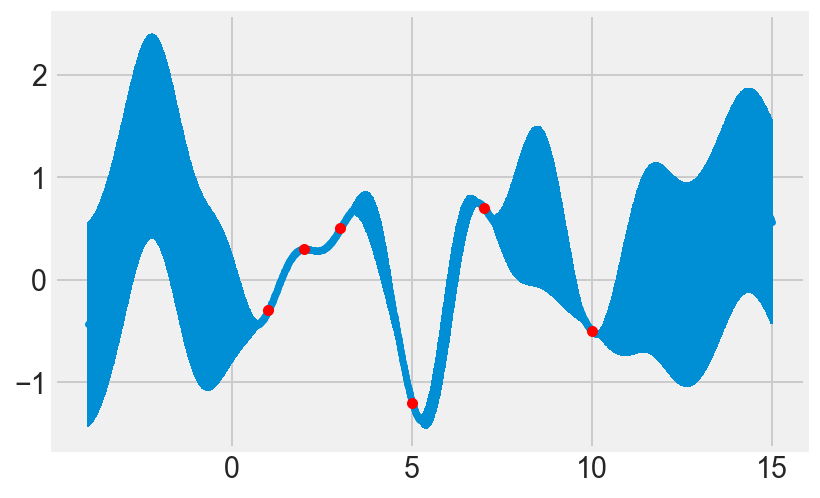

In [150]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(x_pts, y_pts, yerr=variance.diagonal(), capsize=0,zorder=1)
ax.scatter(x, y, c='red',zorder=2)

## Scikit learn

In [151]:
np.array([x]).T

array([[ 1],
       [ 2],
       [ 3],
       [ 5],
       [ 7],
       [10]])

In [152]:
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import RBF

kernel = RBF()
gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
gp.fit(np.array([x]).T, y)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=RBF(length_scale=1), n_restarts_optimizer=0,
                         normalize_y=False, optimizer='fmin_l_bfgs_b',
                         random_state=None)

In [153]:
mean, variance = gp.predict(np.array([x_pts]).T, return_cov=True)

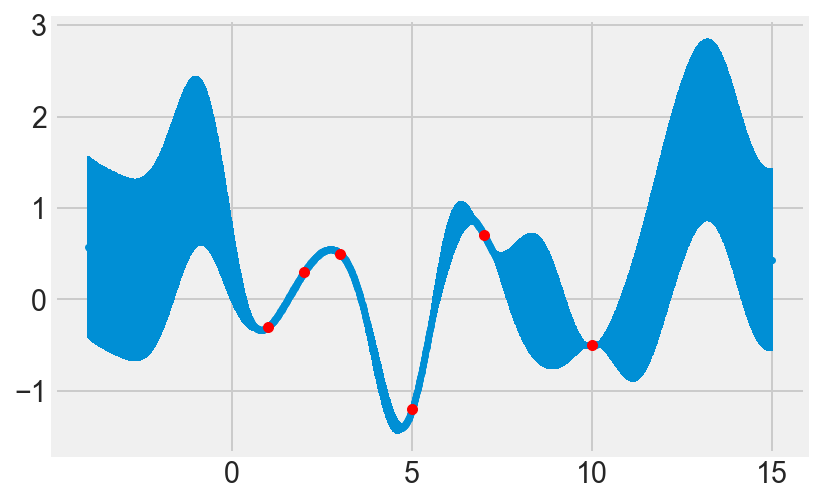

In [154]:
y_pts = np.random.multivariate_normal(mean, variance)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(x_pts, y_pts, yerr=variance.diagonal(), capsize=0,zorder=1)
ax.scatter(x, y, c='red',zorder=2)